In [1]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import scanpy.external as sce
from itertools import islice, cycle
from sklearn.preprocessing import normalize

from ALLCools.clustering import tsne, significant_pc_test, filter_regions, remove_black_list_region, lsi, binarize_matrix
from ALLCools.plot import *

In [2]:
indir = '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/'
metadata_path = f'{indir}AllMpgSmries_Rep1Rep2_HIV_Samples_Only_withFullSampleLabel_allCLoc_RmvExtrCma_withHdr.csv.gz'

HIVmeta = pd.read_csv(metadata_path, index_col=0).sort_index()
HIVmeta[['HIV', 'sampleID', 'replicate', 'wellID', 'cell_type', 'condition']]=HIVmeta.SampleInfo.str.split("_", expand=True)
HIVmeta['sampleID'] = HIVmeta['sampleID'].apply(lambda x: "HIV_" + str(x))
HIVmeta['replicate'] = HIVmeta['replicate'].apply(lambda x: re.sub("R", "Rep", x))
HIVmeta['exposure'] = ['HIV_pre' if x == 'pre' else 'HIV' for x in HIVmeta['condition']]
HIVmeta['Sex'] = 'Male'
HIVmeta['MappingRate'] = (HIVmeta['R1MappedRatio'] + HIVmeta['R2MappedRatio'])/2.0
HIVmeta['FinalmCReads'] = HIVmeta['DeduppedReads']
HIVmeta['mCGFrac'] = HIVmeta['CG_Rate']
print(f'Metadata of {HIVmeta.shape[0]} cells')
pd.set_option('display.max_columns', None)
HIVmeta.index = HIVmeta['SampleInfo']
HIVmeta.head()

Metadata of 19165 cells


index_name  MultiplexReadsTotal  IndexReadsTotal  \
SampleInfo                                                                    
HIV_1_R1_A0_Other-cell_pre      ad001             34255590          4031068   
HIV_1_R1_B0_Other-cell_pre      ad002             34255590          5012910   
HIV_1_R1_A1_Other-cell_pre      ad004             34255590          5243094   
HIV_1_R1_B1_Other-cell_pre      ad006             34255590          5587534   
HIV_3_R1_A0_Other-cell_cro      ad007             34255590          4367786   

                            IndexReadsRatio  IndexBpTotal  IndexTrimedBpTotal  \
SampleInfo                                                                      
HIV_1_R1_A0_Other-cell_pre        11.767621     579804493           496571353   
HIV_1_R1_B0_Other-cell_pre        14.633845     720556253           616844650   
HIV_1_R1_A1_Other-cell_pre        15.305806     754961219           646710720   
HIV_1_R1_B1_Other-cell_pre        16.311306     798640481           682753797   
HIV_3_R1_A0_Other-cell_cro        12.750579     633609127           544084360   

                            IndexTrimedReadsTotal  ReadsQualTrimBpTotal  \
SampleInfo                                                                
HIV_1_R1_A0_Other-cell_pre                3920896               1127041   
HIV_1_R1_B0_Other-cell_pre                4864419               1414577   
HIV_1_R1_A1_Other-cell_pre                5103260               1400092   
HIV_1_R1_B1_Other-cell_pre                5390298               1497622   
HIV_3_R1_A0_Other-cell_cro                4294245               1151022   

                            ReadsLengthFilterTotal  ReadsWithAdapterTotal  \
SampleInfo                                                                  
HIV_1_R1_A0_Other-cell_pre                  110172                   9327   
HIV_1_R1_B0_Other-cell_pre                  148491                  24979   
HIV_1_R1_A1_Other-cell_pre                  139834                  20650   
HIV_1_R1_B1_Other-cell_pre                  197236                  29168   
HIV_3_R1_A0_Other-cell_cro                   73541                   4971   

                            TrimedReadsAveLength  IndexTrimedReadsRatio  \
SampleInfo                                                                
HIV_1_R1_A0_Other-cell_pre            126.647418               0.972669   
HIV_1_R1_B0_Other-cell_pre            126.807467               0.970378   
HIV_1_R1_A1_Other-cell_pre            126.725019               0.973330   
HIV_1_R1_B1_Other-cell_pre            126.663460               0.964701   
HIV_3_R1_A0_Other-cell_cro            126.700819               0.983163   

                               CTOB     CTOT  R1MappedRatio  R1TotalC  \
SampleInfo                                                              
HIV_1_R1_A0_Other-cell_pre   749499   753429           76.7  38971840   
HIV_1_R1_B0_Other-cell_pre   955157   951909           78.4  49214608   
HIV_1_R1_A1_Other-cell_pre   984943   986060           77.3  50615438   
HIV_1_R1_B1_Other-cell_pre  1004493  1005187           74.6  51367294   
HIV_3_R1_A0_Other-cell_cro   822138   823609           76.7  42447444   

                            R1TrimmedReads  R1UniqueMappedReads  \
SampleInfo                                                        
HIV_1_R1_A0_Other-cell_pre         1959825              1502928   
HIV_1_R1_B0_Other-cell_pre         2431668              1907070   
HIV_1_R1_A1_Other-cell_pre         2550914              1971003   
HIV_1_R1_B1_Other-cell_pre         2694362              2009680   
HIV_3_R1_A0_Other-cell_cro         2146736              1645747   

                            R1UnmappedReads  R1UnuniqueMappedReads      OB  \
SampleInfo                                                                   
HIV_1_R1_A0_Other-cell_pre           324193                 132704  691878   
HIV_1_R1_B0_Other-cell_pre           354156                 170442  867641   
HIV_1_R1_A1_Other-c

# 0. Filtering

In [3]:
mapping_rate_cutoff = 50
final_reads_cutoff = 500000
mcg_cutoff = 0.5

15444 / 19165 cells (80.6%) passed the MappingRate cutoff 50.


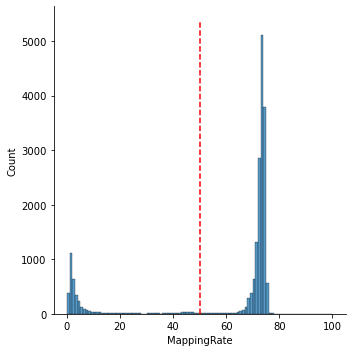

In [4]:
_cutoff = mapping_rate_cutoff
_col_name = 'MappingRate'

metadata=HIVmeta

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 100), bins=100)
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mapping_rate_judge = metadata[_col_name] > _cutoff
_passed_cells = mapping_rate_judge.sum()
total_cell = metadata.shape[0]
print(
    f'{_passed_cells} / {total_cell} cells ({_passed_cells / total_cell * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

14399 / 19165 cells (75.1%) passed the FinalmCReads cutoff 500000.


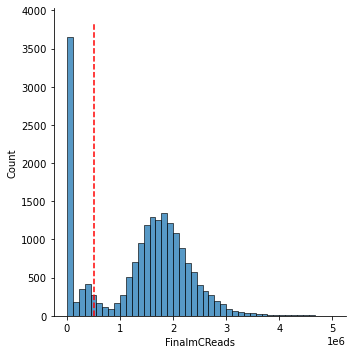

In [5]:
_cutoff = final_reads_cutoff
_col_name = 'FinalmCReads'

total_cells= metadata.shape[0]
# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 5e6))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

final_reads_judge = metadata[_col_name] > _cutoff
_passed_cells = final_reads_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

19082 / 19165 cells (99.6%) passed the mCGFrac cutoff 0.5.


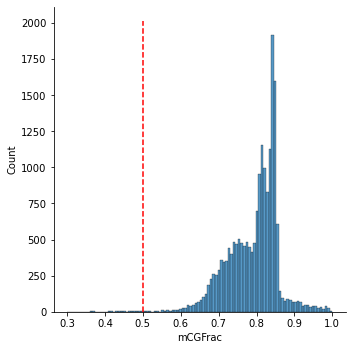

In [6]:
_cutoff = mcg_cutoff
_col_name = 'mCGFrac'

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0.3, 1))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mcg_judge = metadata[_col_name] > _cutoff
_passed_cells = mcg_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

In [7]:
judge = mapping_rate_judge & final_reads_judge & mcg_judge
passed_cells = judge.sum()
print(
    f'{passed_cells} / {total_cells} cells ({passed_cells / total_cells * 100:.1f}%) '
    f'passed all the filters.')

14154 / 19165 cells (73.9%) passed all the filters.


In [8]:
metadata_filtered = metadata[judge].copy()
metadata_filtered.index.name='cell'
metadata_filtered.to_csv('CellMetadata.PassQC.csv.gz')

In [9]:
metadata = metadata_filtered

# 1. read mcad

In [10]:
HIV_mcad_list = ['/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Other-cell_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Tc-Mem_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Th-Mem_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Tc-Naive_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Th-Naive_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_Monocyte_CGN_StrndMrgd_allC.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_B-cell_CGN_StrndMrgd.mcad',
             '/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCAD/MCAD_5kb_NK-cell_CGN_StrndMrgd_allC.mcad']

In [11]:
mcad_list = []
for mcad_path in HIV_mcad_list:
    tmp = anndata.read_h5ad(mcad_path)
    binarize_matrix(tmp, cutoff=0.95)
    mcad_list.append(tmp)

In [12]:
mcad = anndata.AnnData.concatenate(*mcad_list, index_unique=None)[metadata.index].copy()

In [13]:
mcad.obs = pd.concat([mcad.obs, metadata.reindex(mcad.obs_names)], axis=1)

In [14]:
exclude_chroms = mcad.var['chrom'].apply(lambda x: x not in ['chrX', 'chrY', 'chrM'])
mcad = mcad[:,exclude_chroms.index[exclude_chroms]]

In [15]:
from scipy.stats import zscore

mcad.var['n_cell'] = mcad.X.sum(axis=0).A1
mcad._inplace_subset_var(mcad.var['n_cell']>5)
mcad._inplace_subset_var(np.abs(zscore(np.log(mcad.var['n_cell'])))<2)

Trying to set attribute `.var` of view, copying.


In [16]:
from pybedtools import BedTool
import warnings

def remove_black_list_region(adata, black_list_path, f=0.2):
    """
    Remove regions overlap (bedtools intersect -f {f}) with regions in the black_list_path
    Parameters
    ----------
    adata
    black_list_path
        Path to the black list bed file
    f
        Fraction of overlap when calling bedtools intersect
    Returns
    -------
    None
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        feature_bed_df = adata.var[['chrom', 'start', 'end']]
        feature_bed = BedTool.from_dataframe(feature_bed_df)
        black_list_bed = BedTool(black_list_path)
        black_feature = feature_bed.intersect(black_list_bed, f=f, wa=True)
        try:
            black_feature_index = black_feature.to_dataframe().set_index(
                ['chrom', 'start', 'end']).index
            black_feature_id = pd.Index(
                feature_bed_df.reset_index().set_index(['chrom', 'start', 'end']).loc[black_feature_index])
            print(f'{black_feature_id.size} features removed due to overlapping'
                  f' (bedtools intersect -f {f}) with black list regions.')
            adata._inplace_subset_var(~adata.var_names.isin(black_feature_id))
        except pd.errors.EmptyDataError:
            # no overlap with black list
            pass
    return

In [17]:
remove_black_list_region(mcad, black_list_path='/gale/netapp/home/haili2/utils/human/hg38/hg38-blacklist.v2.bed.gz')

13634 features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


In [18]:
mcad.write("HIV_All.h5ad")

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'index_name' as categorical
/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'plate1' as categorical
/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reord

# 2.0 Clustering

In [22]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata

In [23]:
pc_cutoff = 0.1
knn = -1  # -1 means auto determine
# Leiden
resolution = 0.5

In [19]:
lsi(mcad, algorithm='arpack', obsm='X_pca')
mcad.obsm['5kCG_pca'] = mcad.obsm['X_pca'].copy()

NameError: name 'pc_cutoff' is not defined

In [20]:
n_components = significant_pc_test(mcad, p_cutoff=0.1, update=False)

36 components passed P cutoff of 0.1.


In [21]:
# mcad.obsm['X_pca'] = normalize(mcad.obsm['5kCG_pca'][:, :40], axis=1)
mcad.obsm['X_pca'] = mcad.obsm['5kCG_pca'][:,:32]

sc.pp.neighbors(mcad)
sc.tl.leiden(mcad, resolution=0.5)

tsne(mcad, obsm='X_pca', metric='euclidean', exaggeration=-1, perplexity=30, n_jobs=10)


NameError: name 'dump_embedding' is not defined

In [24]:
mcad = dump_embedding(mcad, 'tsne')

mcad.obsm['5kCG_tsne'] = mcad.obsm['X_tsne'].copy()
mcad.obs['all_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['all_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['all_leiden'] = mcad.obs['leiden']

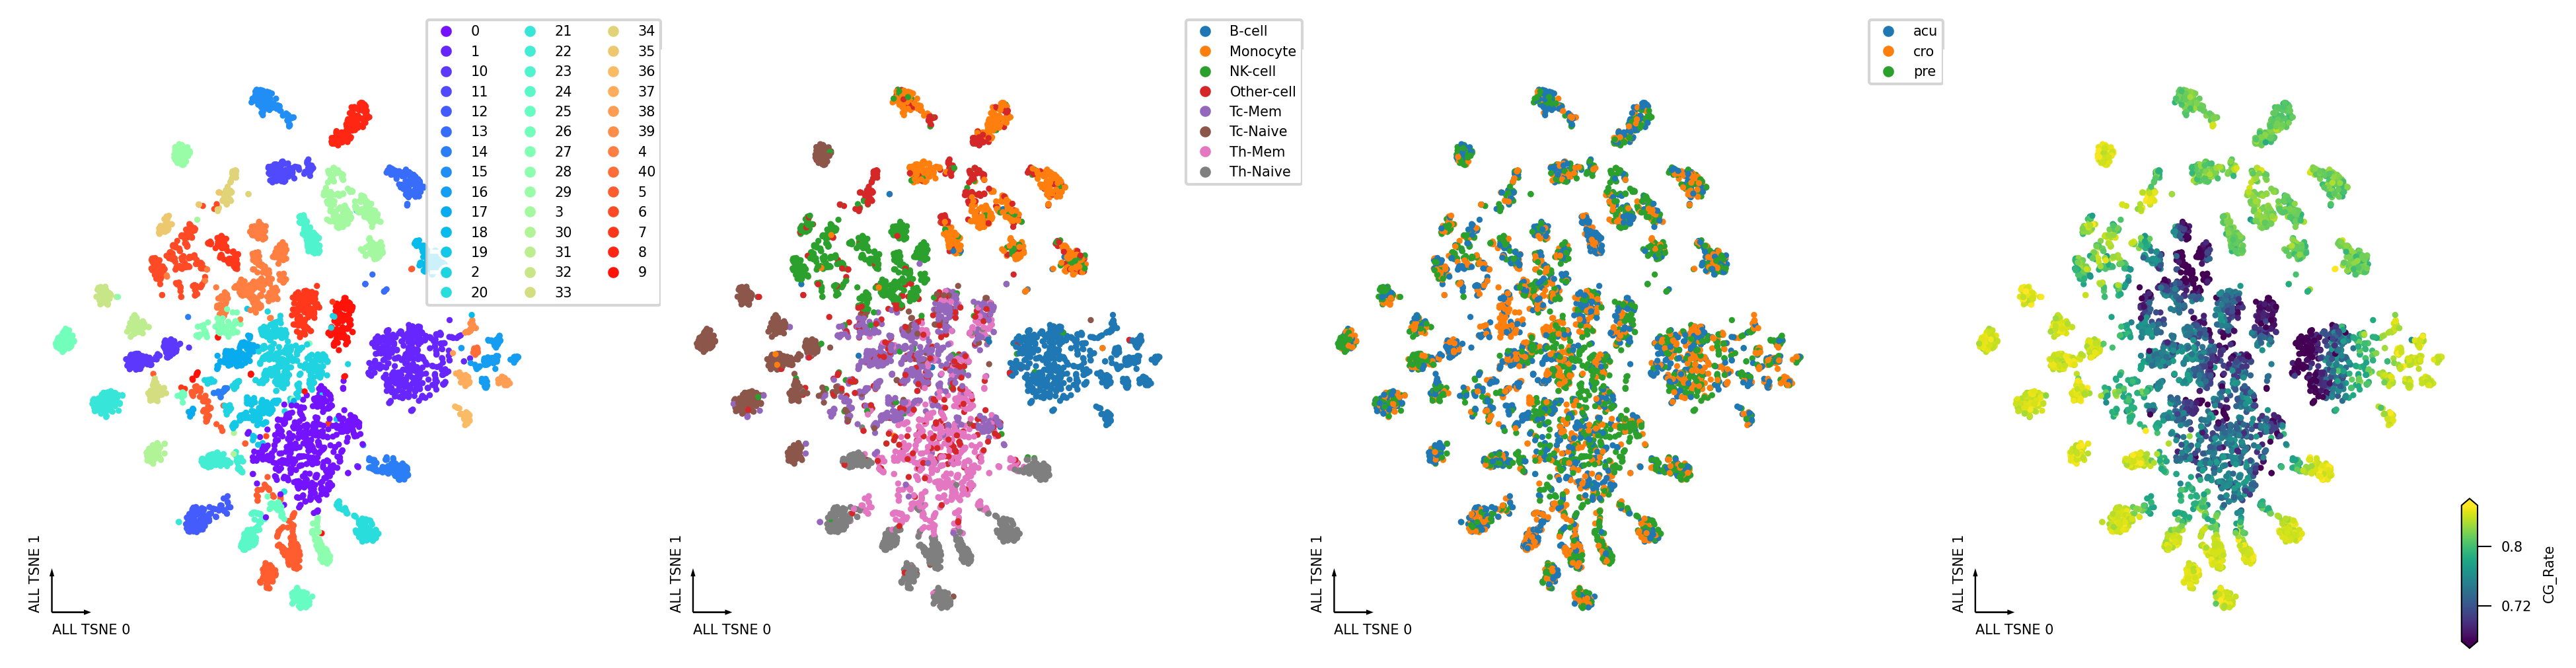

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='all_tsne', hue='all_leiden', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='all_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='all_tsne', hue='condition', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='all_tsne', hue='CG_Rate', labelsize=5)


In [30]:
DonorID_mapping_dict = {
    'HIV_1':'D1',
    'HIV_32':'D1',
    'HIV_3':'D1',    

    'HIV_4':'D2',
    'HIV_5':'D2',
    'HIV_6':'D2',    

    'HIV_7':'D3',
    'HIV_8':'D3',
    'HIV_9':'D3',    

    'HIV_10':'D4',
    'HIV_11':'D4',
    'HIV_12':'D4',    

    'HIV_13':'D5',
    'HIV_14':'D5',
    'HIV_15':'D5',    

    'HIV_16':'D6',
    'HIV_17':'D6',
    'HIV_18':'D6',    

    'HIV_19':'D7',
    'HIV_20':'D7',
    'HIV_21':'D7',    

    'HIV_22':'D8',
    'HIV_23':'D8',
    'HIV_24':'D8',    

    'HIV_25':'D9',
    'HIV_26':'D9',
    'HIV_27':'D9',    
    
}

In [31]:
mcad.obs['DonorID'] = [DonorID_mapping_dict[x] for x in mcad.obs['sampleID']]

In [32]:
sce.pp.harmony_integrate(mcad, 'DonorID', max_iter_harmony=30, random_state=0)
mcad.obsm['5kCG_u30hm'] = mcad.obsm['X_pca_harmony'].copy()
sc.pp.neighbors(mcad, use_rep="5kCG_u30hm")
sc.tl.leiden(mcad, resolution=0.5)

tsne(mcad, obsm='5kCG_u30hm', metric='euclidean', exaggeration=-1, perplexity=30, n_jobs=10)
mcad = dump_embedding(mcad, 'tsne')
mcad.obs['HM_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['HM_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['HM_leiden'] = mcad.obs['leiden']

mcad.obsm['5kCG_u30hm_tsne'] = mcad.obsm['X_tsne'].copy()

2022-06-08 18:03:43,853 - harmonypy - INFO - Iteration 1 of 30
2022-06-08 18:03:51,611 - harmonypy - INFO - Iteration 2 of 30
2022-06-08 18:03:58,975 - harmonypy - INFO - Iteration 3 of 30
2022-06-08 18:04:06,078 - harmonypy - INFO - Iteration 4 of 30
2022-06-08 18:04:09,984 - harmonypy - INFO - Iteration 5 of 30
2022-06-08 18:04:17,252 - harmonypy - INFO - Iteration 6 of 30
2022-06-08 18:04:22,021 - harmonypy - INFO - Iteration 7 of 30
2022-06-08 18:04:25,213 - harmonypy - INFO - Iteration 8 of 30
2022-06-08 18:04:27,957 - harmonypy - INFO - Converged after 8 iterations


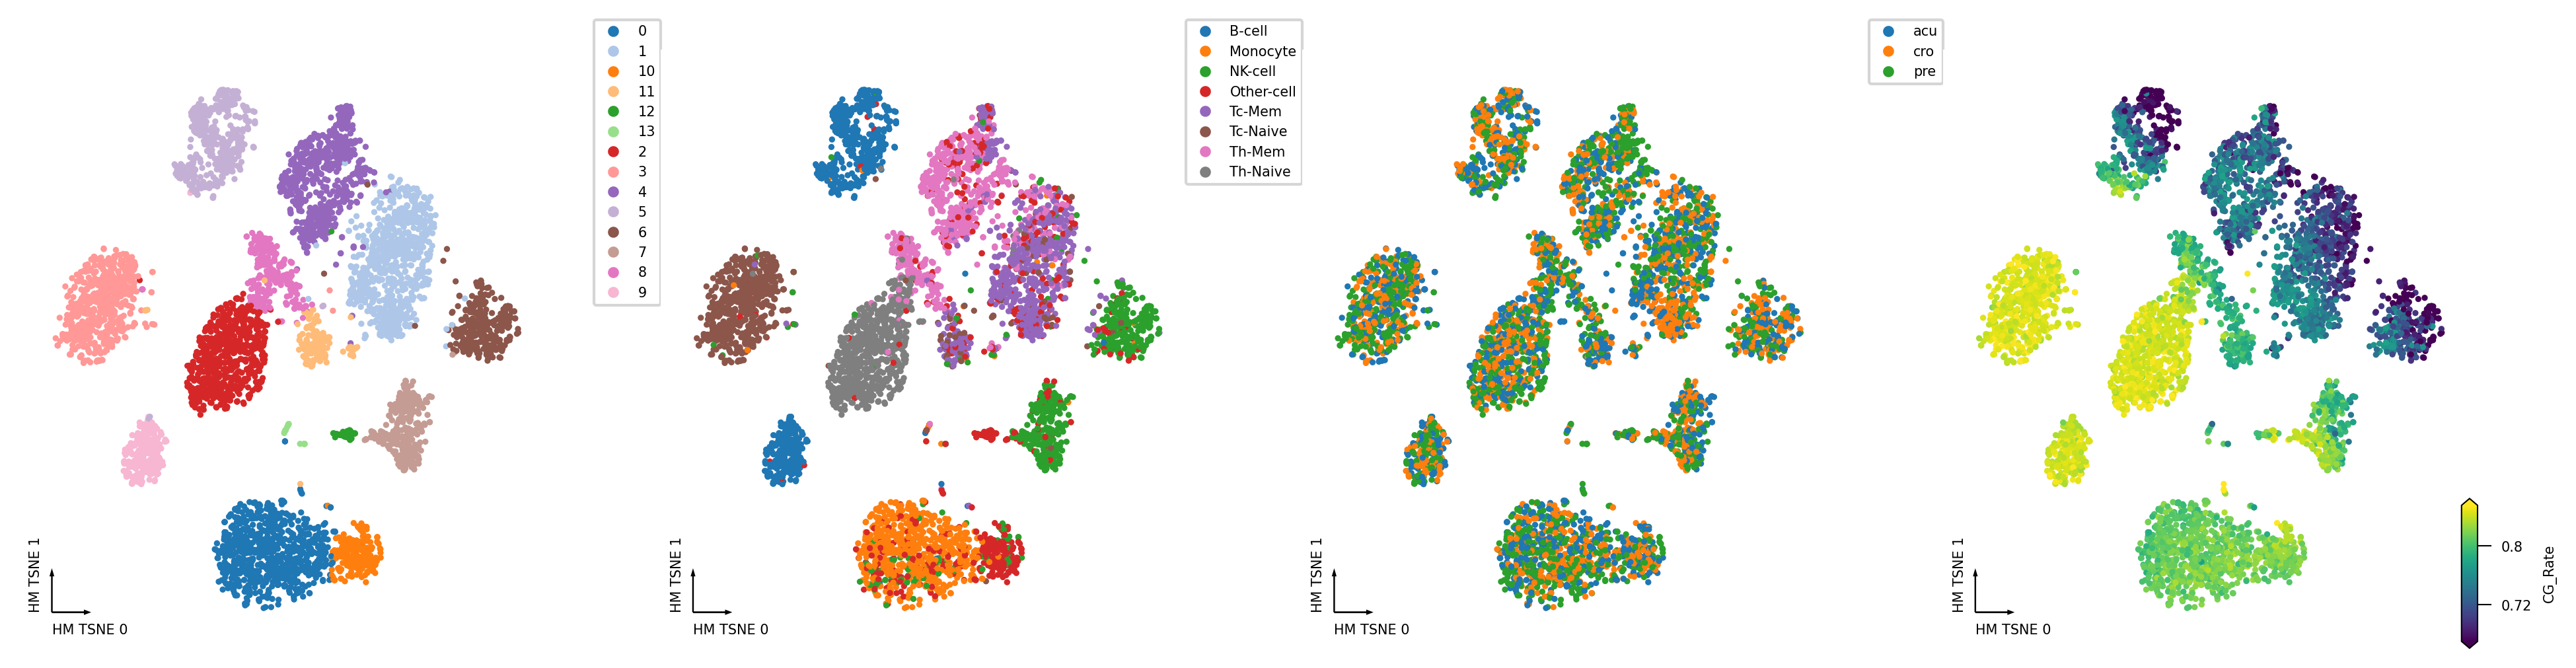

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='HM_tsne', hue='HM_leiden', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5, sizes=0.01)
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='HM_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='HM_tsne', hue='condition', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='HM_tsne', hue='CG_Rate', labelsize=5)
plt.savefig("all_cluster.HM.pdf")

# 3. Celltype annotation

In [35]:
import xarray as xr
import pybedtools
import dask
from ALLCools.plot import *
from ALLCools.mcds import MCDS
import pathlib
import glob

In [36]:
gene_meta_path = '/gale/netapp/DoD/wenliang/database/ref/hg38/Annotation/gencode.v35.annotation.gene.withName.bed'
chrom_to_remove = ['chrM', 'chrX', 'chrY']

# change this to the paths to your MCDS files
mcds_path_list = [
    "/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_B-cell_MCDS.mcds",
    "/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Monocyte_MCDS.mcds",
    "/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_NK-cell_MCDS.mcds",
    "/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Other-cell_MCDS.mcds",
    "/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Tc-Mem_MCDS.mcds",
    "/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Tc-Naive_MCDS.mcds",
    "/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Th-Mem_MCDS.mcds",
    "/gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Th-Naive_MCDS.mcds"
]
obs_dim = 'cell'
var_dim = 'gene'

min_cov = 5

In [37]:
gene_meta = pd.read_csv(gene_meta_path, sep='\t', names=['chrom', 'start', 'end', 'gene_id', 'gene_name'], index_col=3)

genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
gene_bed = pybedtools.BedTool.from_dataframe(
    gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
    for gene_b in gene_b_str.split(','):
        if gene_b != gene_a:
            genes_to_skip.add(gene_b)

# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

36763 features remained


In [38]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    # still use all the cells to load MCDS
    mcds = MCDS.open(mcds_path_list, obs_dim=obs_dim, use_obs=metadata.index)

Feature gene mean cov across cells added in MCDS.coords['gene_cov_mean'].


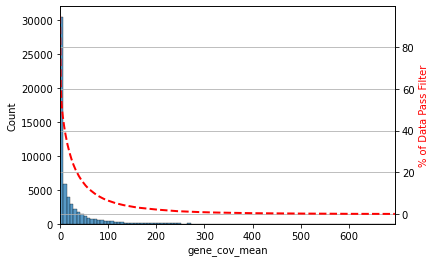

In [39]:
mcds.add_feature_cov_mean(var_dim=var_dim, obs_dim=obs_dim)

In [40]:
feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()

In [41]:
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index

print(f'{use_features.size} features remained')

23172 features remained


/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  """Entry point for launching an IPython kernel.


In [42]:
mcds.filter_feature_by_cov_mean(var_dim, min_cov=min_cov)

Before cov mean filter: 60656 gene
 After cov mean filter: 29130 gene 48.0%


<xarray.MCDS>
Dimensions:              (gene: 29130, cell: 14154, count_type: 2, chrom100k: 30895)
Coordinates: (12/13)
  * gene                 (gene) object 'ENSG00000238009' ... 'ENSG00000237917'
    gene_chrom           (gene) <U1 dask.array<chunksize=(2110,), meta=np.ndarray>
    gene_start           (gene) int32 dask.array<chunksize=(2110,), meta=np.ndarray>
    gene_end             (gene) int32 dask.array<chunksize=(2110,), meta=np.ndarray>
  * cell                 (cell) <U28 'HIV_10_R2_H21_B-cell_pre' ... 'HIV_9_R2...
  * count_type           (count_type) <U3 'mc' 'cov'
    ...                   ...
    mc_type              <U3 'CGN'
    chrom100k_chrom      (chrom100k) <U1 dask.array<chunksize=(4096,), meta=np.ndarray>
  * chrom100k            (chrom100k) int32 0 1 2 3 4 ... 30891 30892 30893 30894
    chrom100k_bin_start  (chrom100k) int32 dask.array<chunksize=(4096,), meta=np.ndarray>
    chrom100k_bin_end    (chrom100k) int32 dask.array<chunksize=(4096,), meta=np.ndarray>
    gene_cov_mean        (gene) float64 6.045 5.714 5.818 ... 11.77 15.38 14.37
Data variables:
    gene_da              (cell, gene, count_type) int32 dask.array<chunksize=(2830, 2110, 1), meta=np.ndarray>
    chrom100k_da         (cell, chrom100k, count_type) int32 dask.array<chunksize=(2830, 4096, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  null

In [43]:
gene_frac_dir = pathlib.Path('gene_frac_raw')
gene_frac_dir.mkdir(exist_ok=True)

In [44]:
for mcds_path in mcds_path_list:
    output_path = gene_frac_dir / (pathlib.Path(mcds_path).name + f'{var_dim}_da_frac.mcds')
    if output_path.exists():
        continue
    print(f'Computaing gene mC fraction for {mcds_path}')
    mcds = MCDS.open(mcds_path, obs_dim=obs_dim)
    # remove non-related data
    del_das = []
    for da in mcds:
        if da != f'{var_dim}_da':
            del_das.append(da)
    for da in del_das:
        del mcds[da]
    mcds.load()
    mcds = mcds.sel({var_dim: use_features})
    mcds.add_mc_rate(var_dim=var_dim, normalize_per_cell=True, clip_norm_value=10)
    # use float32 to reduce file size and speedup IO
    mcds = mcds.rename({var_dim: 'gene', f'{var_dim}_da_frac': 'gene_da_frac'})
    mcds['gene_da_frac'].astype('float32').to_netcdf(output_path)

Computaing gene mC fraction for /gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_B-cell_MCDS.mcds
Computaing gene mC fraction for /gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Monocyte_MCDS.mcds
Computaing gene mC fraction for /gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_NK-cell_MCDS.mcds
Computaing gene mC fraction for /gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Other-cell_MCDS.mcds
Computaing gene mC fraction for /gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Tc-Mem_MCDS.mcds
Computaing gene mC fraction for /gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Tc-Naive_MCDS.mcds
Computaing gene mC fraction for /gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_Th-Mem_MCDS.mcds
Computaing gene mC fraction for /gale/netapp/scratch/manoj/ECHO/CommonFiles/SAFER/HIV/MCDS/AllReps_StrndMrgd_

In [45]:
use_gene_meta = gene_meta.loc[use_features]
use_gene_meta.to_csv(gene_frac_dir / 'GeneMetadata.csv.gz')

In [46]:
Markers = ['CD38', 'CXCR5', 'CD34', 'CD80', 'TNFRSF13B', 'CD40', 'IGHM', 'CD5', 'MS4A1', 'CD24', 'CD79A', 'CXCR4', 'CD22', 'IGHD']\
        + ['CD14', 'CD36', 'CCR2', 'CD74', 'CLEC9A']\
        + ['NCAM1']\
        + ['MKI67']\
        + ['CD4', 'CD40LG', 'CD8A', 'CD8B', 'SELL', 'CCR7', 'NR4A1', 'CX3CR1', 'CD45RA']

In [47]:
gene_meta = pd.read_csv(f'{gene_frac_dir}/GeneMetadata.csv.gz', index_col=0)
gene_meta.index.name = 'gene_id'

name2id = dict(zip(gene_meta['gene_name'], gene_meta.index))
marker_gene_ids = [name2id[x] for x in Markers if x in name2id]

gene_frac_da = MCDS.open(f'{gene_frac_dir}/*_da_frac.mcds')[f'gene_da_frac']
gene_frac_da = gene_frac_da.expand_dims(dim={'mc_type': ['CGN']})
genes_data = gene_frac_da.sel(mc_type='CGN').sel(gene=marker_gene_ids).squeeze().to_pandas()
genes_data.columns = genes_data.columns.map(gene_meta['gene_name'])
genes_data

gene                           CD38     CXCR5      CD34      CD80  TNFRSF13B  \
cell                                                                           
HIV_10_R2_G18_B-cell_pre   1.000000  1.000000  1.000000  1.000000   1.000000   
HIV_10_R2_H21_B-cell_pre   1.014705  0.900874  1.070153  1.070153   1.144759   
HIV_10_R2_G21_B-cell_pre   1.059589  1.142629  0.314547  1.178870   0.934637   
HIV_10_R2_H19_B-cell_pre   1.122331  0.457145  0.830552  0.843964   1.149872   
HIV_10_R2_H20_B-cell_pre   1.204021  0.625632  0.786111  0.877950   1.145304   
...                             ...       ...       ...       ...        ...   
HIV_9_R2_L17_Th-Naive_cro  1.252586  1.163453  1.085084  1.074135   1.171282   
HIV_9_R2_L14_Th-Naive_cro  0.790565  1.213013  1.094616  1.086768   1.116526   
HIV_9_R2_L16_Th-Naive_cro  0.904179  1.227229  0.627926  1.050241   1.140798   
HIV_9_R2_K15_Th-Naive_cro  1.198632  1.119459  0.456890  1.242496   1.159543   
HIV_9_R2_K17_Th-Naive_cro  0.883355  1.221865  0.728545  1.232791   1.143817   

gene                           CD40      IGHM       CD5     MS4A1      CD24  \
cell                                                                          
HIV_10_R2_G18_B-cell_pre   1.000000  1.000000  1.000000  1.000000  1.000000   
HIV_10_R2_H21_B-cell_pre   1.133064  1.000000  1.262328  1.019266  0.185312   
HIV_10_R2_G21_B-cell_pre   0.451762  0.957445  1.070502  0.568064  1.000000   
HIV_10_R2_H19_B-cell_pre   1.142043  0.101671  1.221036  0.999793  0.250858   
HIV_10_R2_H20_B-cell_pre   1.122526  1.000000  1.196007  0.840397  1.000000   
...                             ...       ...       ...       ...       ...   
HIV_9_R2_L17_Th-Naive_cro  1.200870  1.185189  0.757758  1.161735  0.098970   
HIV_9_R2_L14_Th-Naive_cro  0.862430  1.152965  1.002934  1.187000  0.137925   
HIV_9_R2_L16_Th-Naive_cro  0.986141  1.000000  0.445925  1.185847  0.312837   
HIV_9_R2_K15_Th-Naive_cro  1.225861  1.060545  1.131707  1.109949  1.088611   
HIV_9_R2_K17_Th-Naive_cro  1.181578  1.196460  0.901824  1.196901  0.254097   

gene                          CD79A     CXCR4      CD22      IGHD      CD14  \
cell                                                                          
HIV_10_R2_G18_B-cell_pre   1.000000  1.000000  1.000000  1.000000  1.000000   
HIV_10_R2_H21_B-cell_pre   0.312681  0.159349  0.333390  1.245222  1.000000   
HIV_10_R2_G21_B-cell_pre   1.000000  1.121151  0.940324  1.194298  1.000000   
HIV_10_R2_H19_B-cell_pre   1.000000  1.000000  0.771518  1.200281  1.000000   
HIV_10_R2_H20_B-cell_pre   0.473599  0.391815  0.158516  1.173182  1.000000   
...                             ...       ...       ...       ...       ...   
HIV_9_R2_L17_Th-Naive_cro  1.233101  0.552469  1.101983  1.184109  1.000000   
HIV_9_R2_L14_Th-Naive_cro  1.000000  0.195695  1.198830  1.000000  1.000000   
HIV_9_R2_L16_Th-Naive_cro  0.526495  1.000000  0.935051  1.185847  0.086618   
HIV_9_R2_K15_Th-Naive_cro  1.174025  0.900447  0.872457  1.174025  0.212922   
HIV_9_R2_K17_Th-Naive_cro  1.220121  0.281224  1.075280  1.224981  1.000000   

gene                           CD36      CCR2      CD74    CLEC9A     NCAM1  \
cell                                                                          
HIV_10_R2_G18_B-cell_pre   1.000000  1.000000  1.000000  1.000000  1.000000   
HIV_10_R2_H21_B-cell_pre   0.978560  1.000000  0.864463  0.831550  0.928042   
HIV_10_R2_G21_B-cell_pre   1.079710  1.083451  0.939552  1.031163  1.029142   
HIV_10_R2_H19_B-cell_pre   1.136075  0.899197  1.101640  0.994510  1.104627   
HIV_10_R2_H20_B-cell_pre   1.068995  0.507613  0.114155  0.973360  1.002099   
...                             ...       ...       ...       ...       ...   
HIV_9_R2_L17_Th-Naive_cro  1.147654  0.955797  1.143076  1.225693  1.102686   
HIV_9_R2_L14_Th-Naive_cro  1.120485  0.943760  1.114023  1.193262  1.081083   
HIV_9_R2_L16_Th-Naive_cro  1.196197  1.185847  1.161958  1.048847  1.034000   
HIV_9_R2_K15_Th-Naive_cro  1.09171

In [48]:
genes_data = genes_data.loc[mcad.obs.index].drop_duplicates()

In [50]:
genes_data = genes_data[~genes_data.index.duplicated(keep='first')]

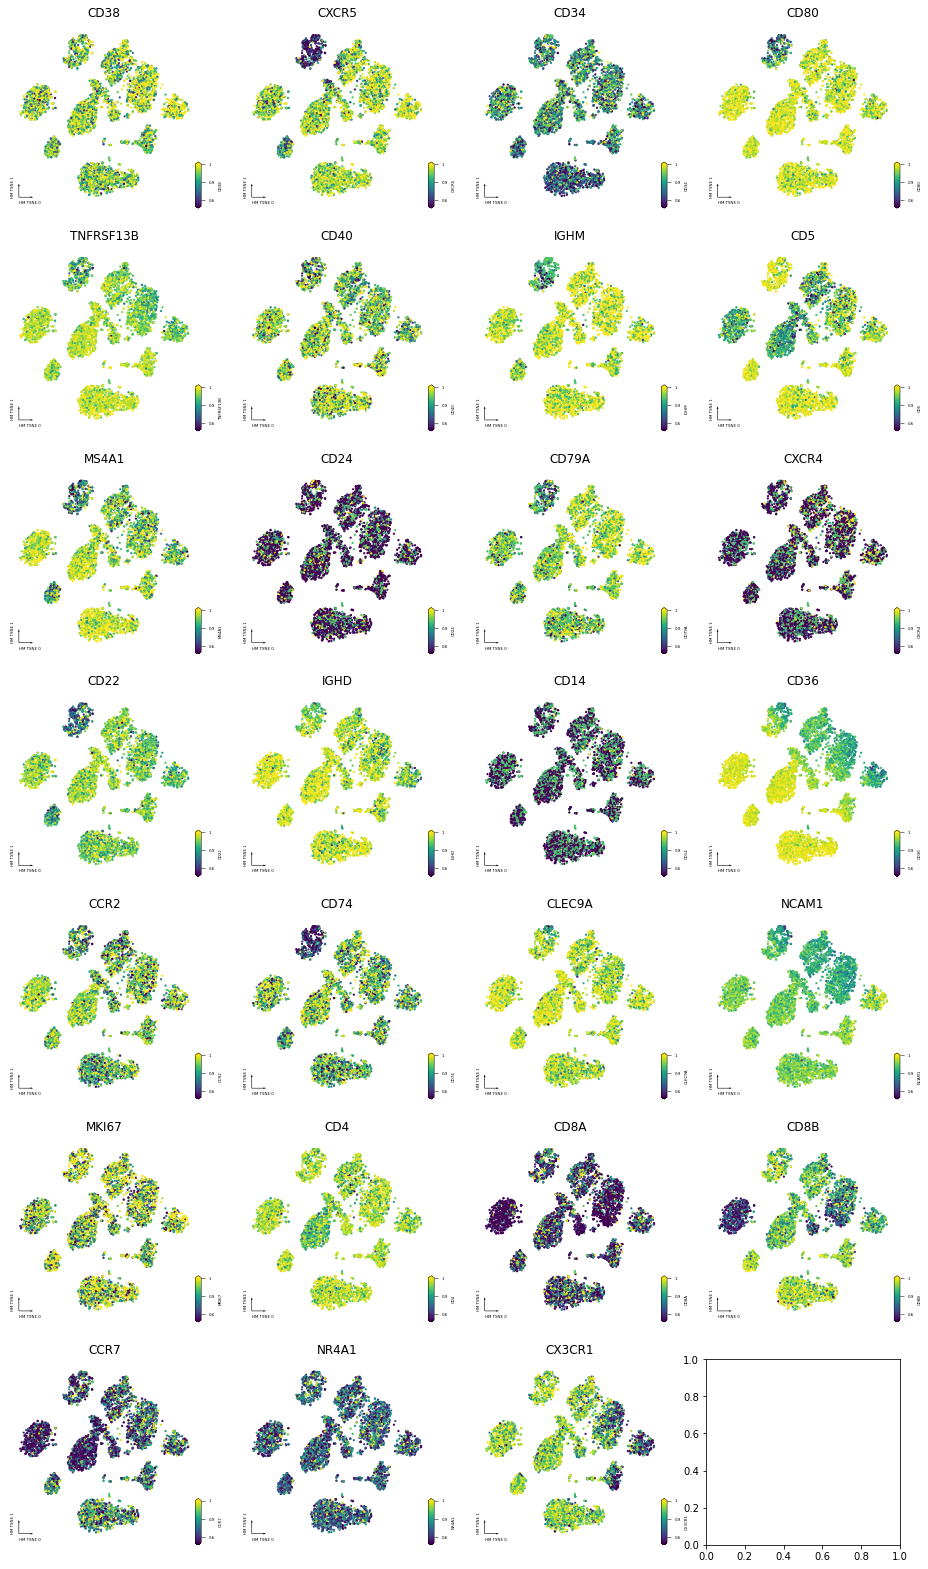

In [52]:
fig, axes = plt.subplots(7, 4, figsize=(16, 28))
axes = axes.flatten()
for i, (gene, data) in enumerate(genes_data.iteritems()):
    ax = axes[i]
    continuous_scatter(ax=ax,
                       data=mcad.obs,
                       hue=data,
                       coord_base='HM_tsne',
                      hue_norm=[0.5, 1.2])
    ax.set_title(f'{data.name}')

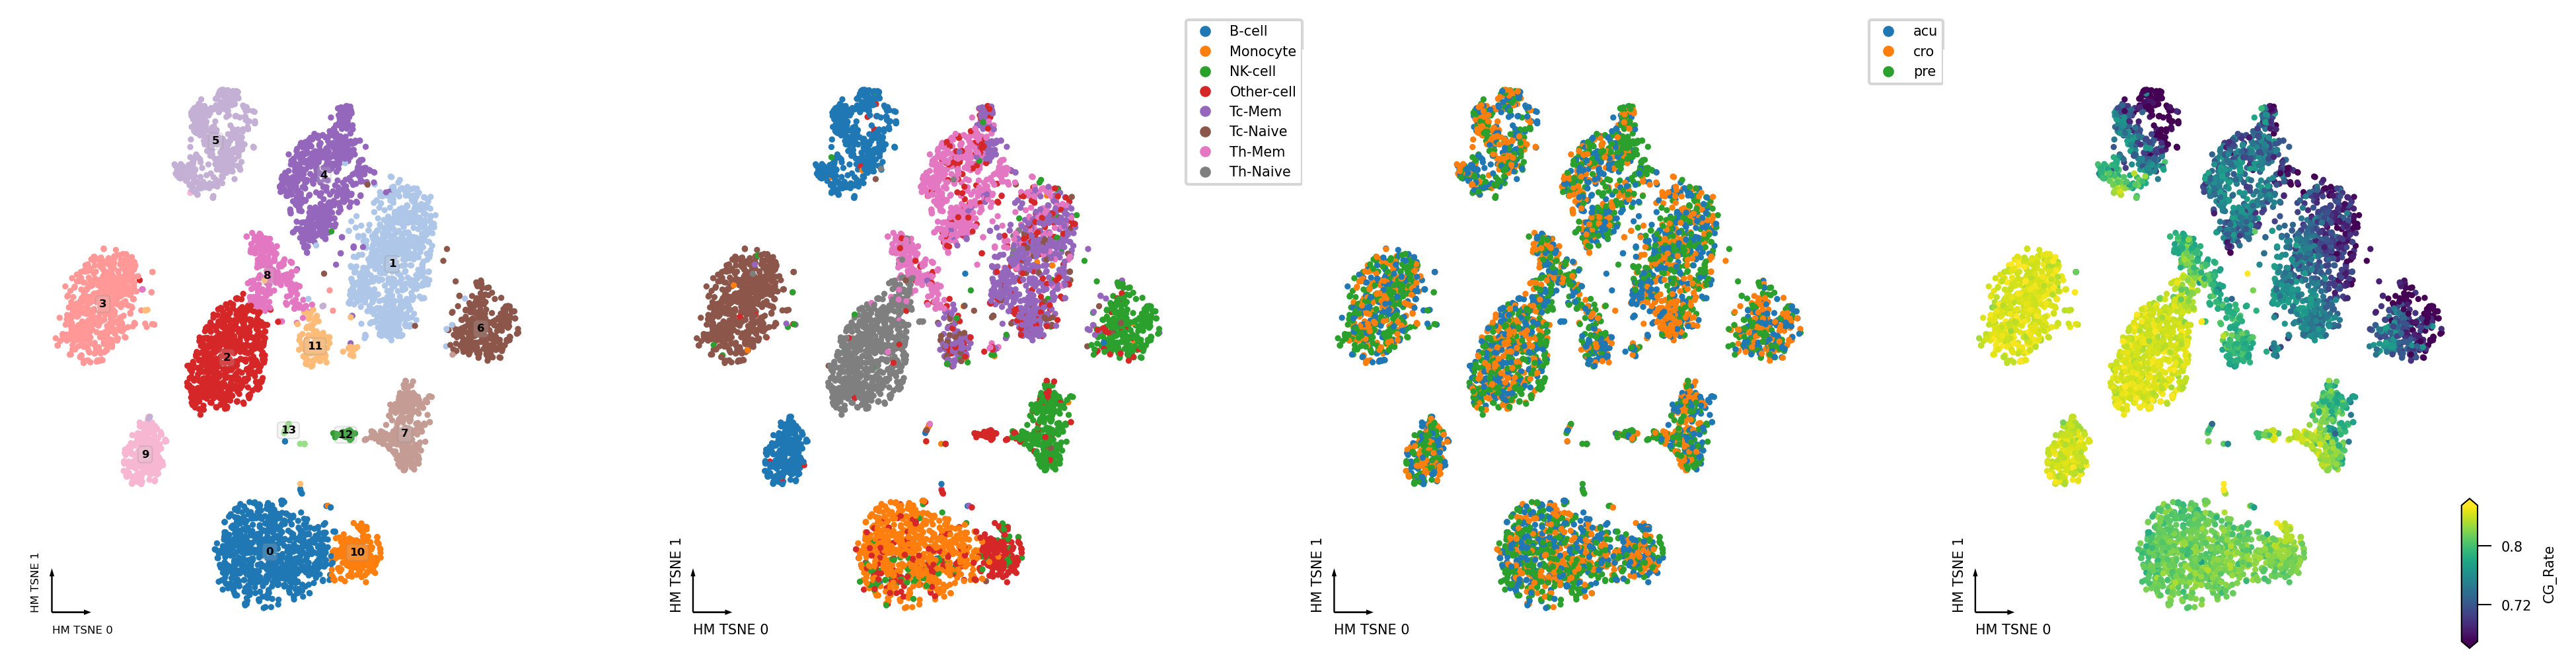

In [54]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='HM_tsne', hue='HM_leiden', show_legend=False, 
#                         legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                            text_anno="HM_leiden")
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='HM_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='HM_tsne', hue='condition', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='HM_tsne', hue='CG_Rate', labelsize=5)

In [63]:
leiden2celltype = {
                  6: 'NK-cell1',
                  7: 'NK-cell2',
                  5: 'B-Mem',
                  9: 'B-Naive'}

In [64]:
mcad.obs['annotation'] = mcad.obs.apply(lambda row: leiden2celltype[int(row['HM_leiden'])] if int(row['HM_leiden']) in leiden2celltype else row['cell_type'], axis=1)

In [65]:
mcad.write_h5ad("HIV_All.TSNE.HM.Annotation.h5ad")

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


In [14]:
mcad.obs.to_csv("cell2cluster.csv")

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [2]:
cell2cluster = pd.read_csv("cell2cluster.csv")

In [3]:
cell2cluster.shape

(14154, 75)

In [4]:
cell2cluster = cell2cluster[cell2cluster['cell_type'] != "Other-cell"]

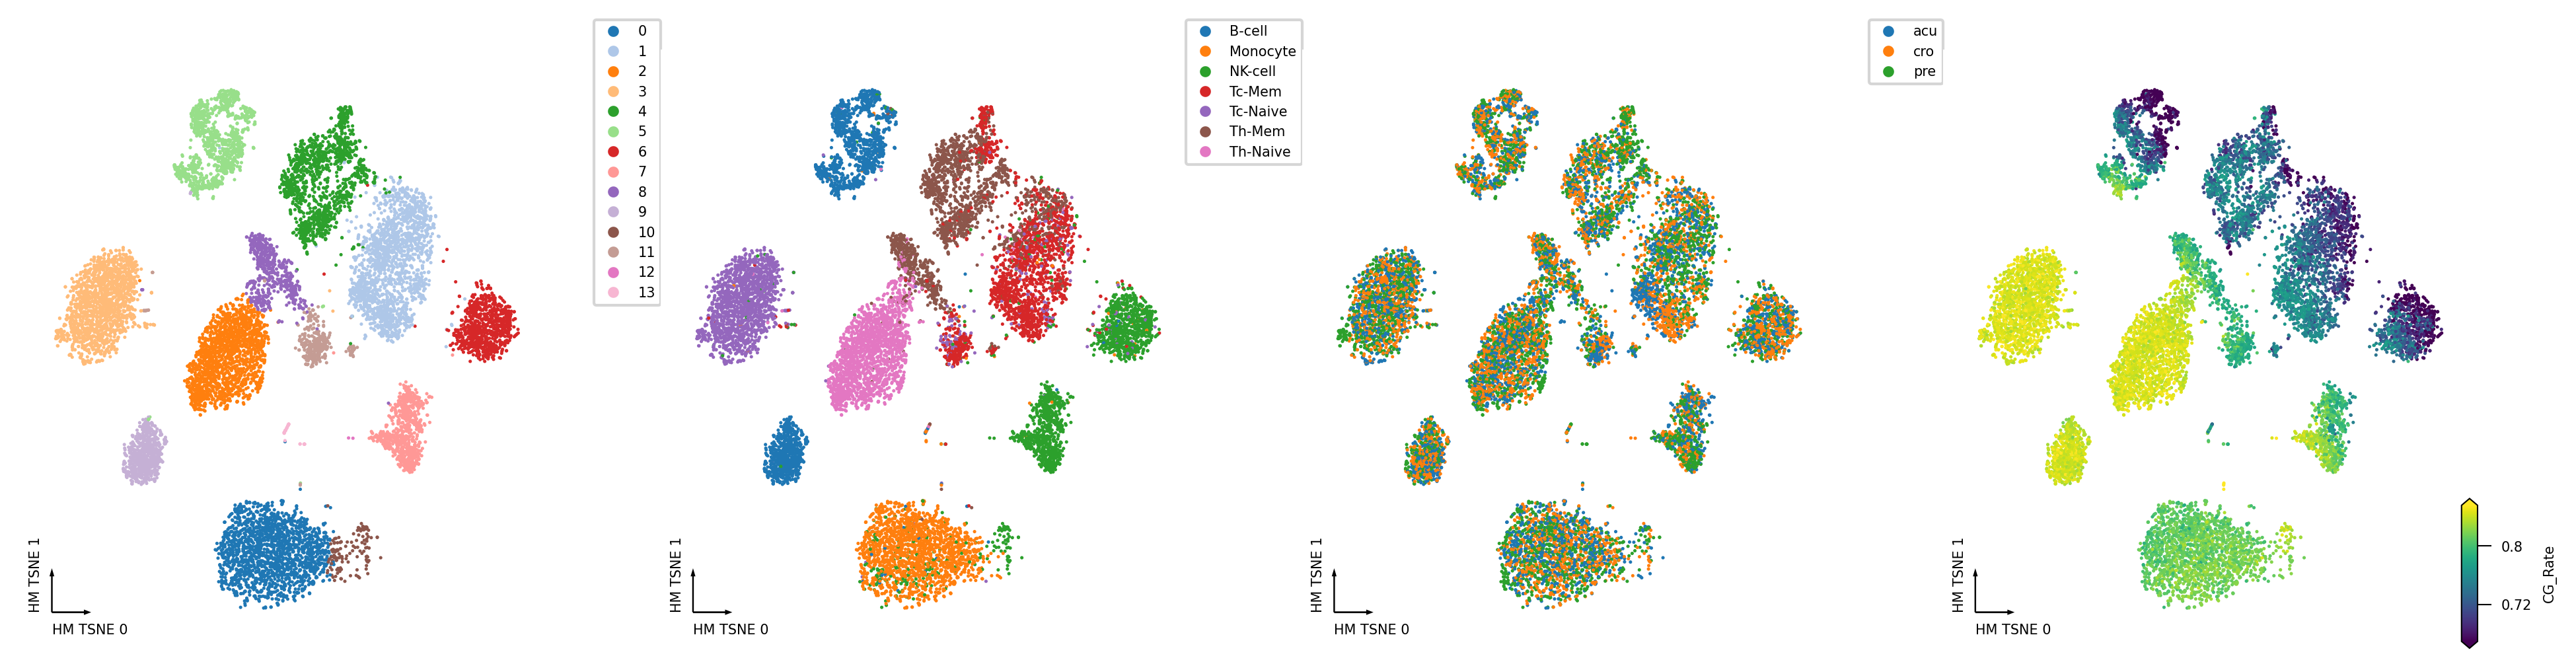

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=cell2cluster, ax=axes[0], coord_base='HM_tsne', hue='HM_leiden', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5, sizes=0.01)
_ = categorical_scatter(data=cell2cluster, ax=axes[1], coord_base='HM_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=cell2cluster, ax=axes[2], coord_base='HM_tsne', hue='condition', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=cell2cluster, ax=axes[3], coord_base='HM_tsne', hue='CG_Rate', labelsize=5)
plt.savefig("HIV_all_cluster.HM.pdf")

In [11]:
mcad = anndata.read_h5ad("HIV_All.TSNE.HM.Annotation.h5ad")

In [12]:
mcad

AnnData object with n_obs × n_vars = 14154 × 497527
    obs: 'batch', 'index_name', 'MultiplexReadsTotal', 'IndexReadsTotal', 'IndexReadsRatio', 'IndexBpTotal', 'IndexTrimedBpTotal', 'IndexTrimedReadsTotal', 'ReadsQualTrimBpTotal', 'ReadsLengthFilterTotal', 'ReadsWithAdapterTotal', 'TrimedReadsAveLength', 'IndexTrimedReadsRatio', 'CTOB', 'CTOT', 'R1MappedRatio', 'R1TotalC', 'R1TrimmedReads', 'R1UniqueMappedReads', 'R1UnmappedReads', 'R1UnuniqueMappedReads', 'OB', 'OT', 'R2MappedRatio', 'R2TotalC', 'R2TrimmedReads', 'R2UniqueMappedReads', 'R2UnmappedReads', 'R2UnuniqueMappedReads', 'TotalUniqueMappedReads', 'TotalMappedRatio', 'DupReads', 'TotalReadsBeforeDeDup', 'DeduppedReads', 'DeduppedRatio', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'genome_cov', 'plate1', 'plate2', 'Pos96', 'real_plate', 'Col96', 'Row96', 'Col384', 'Row384', 'Pos384', 'SampleInfo', 'BothRepMrgdallCLoc', 'HIV', 'sampleID', 'replicate', 'wellID', 'cell_type', 'condition', 'exposure', 'Sex', 'Mapp

In [5]:
from collections import defaultdict, Counter

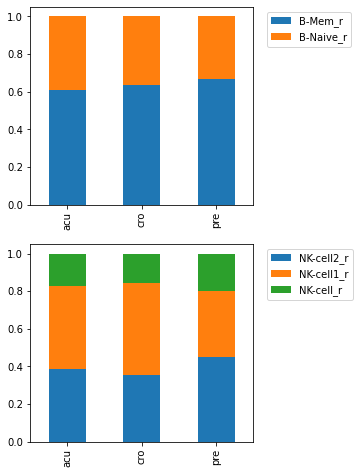

In [10]:
fig, axes = plt.subplots(2,1, figsize=(4,8))
for i, celltype in enumerate(['B-cell', 'NK-cell']):
    cell_df = cell2cluster[cell2cluster['cell_type'] == celltype]
    count_dict = cell_df[['condition', 'annotation']].value_counts().to_dict()
    
    cell_counter = defaultdict(Counter)
    for (cond, cell) in count_dict:
        if count_dict[(cond, cell)] < 50:
            continue
        cell_counter[cond][cell] = count_dict[(cond, cell)]
        cell_counter[cond]['total'] += count_dict[(cond, cell)]
    cell_counter_df = pd.DataFrame.from_dict(cell_counter, orient='index')
    for cell in cell_counter_df.columns:
        if cell == 'total':
            continue
        cell_counter_df[f'{cell}_r'] = cell_counter_df.apply(lambda row: row[cell] / row['total'], axis=1)
    cell_counter_df[[x for x in cell_counter_df.columns if x.endswith("_r")]].sort_index().plot.bar(stacked=True, ax=axes[i])
    axes[i].legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('HIV_B-NK_ratio.pdf')

In [16]:
from scipy.stats import fisher_exact
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

In [11]:
cell_counter_df

NK-cell2  total  NK-cell1  NK-cell  NK-cell2_r  NK-cell1_r  NK-cell_r
pre       295    656       231      130    0.449695    0.352134   0.198171
cro       204    572       279       89    0.356643    0.487762   0.155594
acu       223    578       254      101    0.385813    0.439446   0.174740

In [18]:
chi2_contingency(cell_counter_df.loc[['pre', 'cro'], ['NK-cell2', 'NK-cell1', 'NK-cell']])

(23.15103406928307,
 9.393270450064644e-06,
 2,
 array([[266.56677524, 272.44299674, 116.99022801],
        [232.43322476, 237.55700326, 102.00977199]]))

In [12]:
cell2cluster =  cell2cluster[~cell2cluster['annotation'].isin(['B-cell', 'NK-cell', 'Other-cell'])]

<AxesSubplot:xlabel='annotation', ylabel='CG_Rate'>

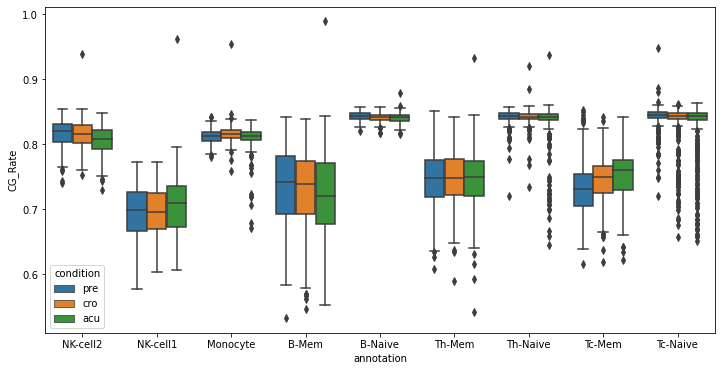

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
sns.boxplot(data=cell2cluster, x='annotation', y='CG_Rate', hue='condition')